In [0]:
# RNN _  many to many (equal size)
#I used teacher forcing and didn't consider schadule sampling, for more robust results, you should implement schadule sampling! 
#import packages

import tensorflow as tf
import numpy as np
import torch
import torch.cuda as cuda
import matplotlib.pyplot as plt


In [2]:
#getting datase with tensorflow
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')


1122304/1115394 [==============================] - 0s 0us/step


In [0]:
corpus = open(path_to_file, 'rb').read().decode(encoding='utf-8')

In [4]:
print("Number of words in the corpus: ",len(corpus))
text=corpus.splitlines()
print("Number of lines in the corpus: ",len(text))

print("The first line of corpus is => ",text[0])
# create train, test and validation set
for i in range(len(text)):
  text[i]=text[i]+" <end>" ## adding <end> at end of each line 
print("Now the first line of corpus is => ",text[0]) 


words=' '.join(text)
words=words.split()
print("printing the 0th to 100th  words of corpus : ",words[0:100])
## later, we use these words for creating vocabulary 
## we dont consider spaces and new lines!







Number of words in the corpus:  1115394
Number of lines in the corpus:  40000
The first line of corpus is =>  First Citizen:
Now the first line of corpus is =>  First Citizen: <end>
printing the 0th to 100th  words of corpus :  ['First', 'Citizen:', '<end>', 'Before', 'we', 'proceed', 'any', 'further,', 'hear', 'me', 'speak.', '<end>', '<end>', 'All:', '<end>', 'Speak,', 'speak.', '<end>', '<end>', 'First', 'Citizen:', '<end>', 'You', 'are', 'all', 'resolved', 'rather', 'to', 'die', 'than', 'to', 'famish?', '<end>', '<end>', 'All:', '<end>', 'Resolved.', 'resolved.', '<end>', '<end>', 'First', 'Citizen:', '<end>', 'First,', 'you', 'know', 'Caius', 'Marcius', 'is', 'chief', 'enemy', 'to', 'the', 'people.', '<end>', '<end>', 'All:', '<end>', 'We', "know't,", 'we', "know't.", '<end>', '<end>', 'First', 'Citizen:', '<end>', 'Let', 'us', 'kill', 'him,', 'and', "we'll", 'have', 'corn', 'at', 'our', 'own', 'price.', '<end>', "Is't", 'a', 'verdict?', '<end>', '<end>', 'All:', '<end>', 'No', 'm

In [5]:
#create vocabulary

voc=[]

def return_index(word):
  return voc.index(word)
 
for word in words :
  if word not in voc:
    voc.append(word)
    
print("The index of  word (The) in vocabulary: ",return_index('The') )
print("The word for index (203): ",voc[203] )

print("Vocab lenght: ",len(voc))

The index of  word (The) in vocabulary:  203
The word for index (203):  The
Vocab lenght:  25671


In [6]:
# converting words to indexes and save it in words_indexes
words_indexes=[return_index(word) for word in words]
print("printing some first indexes : ",words_indexes[0:100])
## its our network input! we use words_indexes  to feed the network


printing some first indexes :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 2, 11, 2, 12, 10, 2, 2, 0, 1, 2, 13, 14, 15, 16, 17, 18, 19, 20, 18, 21, 2, 2, 11, 2, 22, 23, 2, 2, 0, 1, 2, 24, 25, 26, 27, 28, 29, 30, 31, 18, 32, 33, 2, 2, 11, 2, 34, 35, 4, 36, 2, 2, 0, 1, 2, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 2, 49, 50, 51, 2, 2, 11, 2, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 2, 2, 62]


In [7]:

seq_lenght=35 # the lenght of rnn (the lenght of input)
batch_size=20
# how many batches(with size: [batch_size, seq_lenght])  we have for words_indexes array ?
# the answer is len(words_indexes/(batch_size*seq_lenght))
max_batches=int(len(words_indexes)/(batch_size*seq_lenght))
print("the maximum numbers of batcheswith these setting(batch_size,seq_lenght) :  ",max_batches)



trainsetX=words_indexes[0:int(0.9*max_batches)*batch_size*seq_lenght]
trainsetY=words_indexes[1:int(0.9*max_batches)*batch_size*seq_lenght+1]
validsetX=words_indexes[int(0.9*max_batches)*batch_size*seq_lenght:int(1*max_batches)*batch_size*seq_lenght]
validsetY=words_indexes[int(0.9*max_batches)*batch_size*seq_lenght + 1:int(1*max_batches)*batch_size*seq_lenght +1]


the maximum numbers of batcheswith these setting(batch_size,seq_lenght) :   346


In [8]:
##Creating batches

def create_batch(data,flag):
  if flag=='Train':
     return (np.array(data).reshape(int(0.9*max_batches) ,batch_size ,seq_lenght)) # shape(numer of batch, batch_size,seq_enght)
  else :
     return (np.array(data).reshape(int(1*max_batches)-int(0.9*max_batches) ,batch_size ,seq_lenght)) # shape(numer of batch, batch_size,seq_enght)
  
trainX_batches =create_batch(trainsetX,'Train')
trainY_batches =create_batch(trainsetY,'Train')

validX_batches =create_batch(validsetX,'Valid')
validY_batches =create_batch(validsetY,'Valid')


print("trainX_batches_shape: ",trainX_batches.shape)
print("trainY_batches_shape: ",trainY_batches.shape)

print("validX_batches_shape: ",validX_batches.shape)
print("validY_batches_shape: ",validY_batches.shape)

trainX_batches_shape:  (311, 20, 35)
trainY_batches_shape:  (311, 20, 35)
validX_batches_shape:  (35, 20, 35)
validY_batches_shape:  (35, 20, 35)


In [9]:
print(trainX_batches[0,0,:]) # batchNumber=0 , 0th sample in the batch , all of the seq lenght
print(trainY_batches[0,0,:])
print(len(words_indexes))

[ 0  1  2  3  4  5  6  7  8  9 10  2  2 11  2 12 10  2  2  0  1  2 13 14
 15 16 17 18 19 20 18 21  2  2 11]
[ 1  2  3  4  5  6  7  8  9 10  2  2 11  2 12 10  2  2  0  1  2 13 14 15
 16 17 18 19 20 18 21  2  2 11  2]
242651


In [0]:
# now pack these information into one function
def get_batches():# use in training 
  global  words_indexes
  a=[]
  b=[]
    ## shuffling  words_indexes
  a=words_indexes[0:int(0.2*len(words_indexes))]
  b=words_indexes[int(0.2*len(words_indexes)):]
  words_indexes=b+a

  trainsetX=words_indexes[0:int(0.9*max_batches)*batch_size*seq_lenght]
  trainsetY=words_indexes[1:int(0.9*max_batches)*batch_size*seq_lenght+1]
  validsetX=words_indexes[int(0.9*max_batches)*batch_size*seq_lenght:int(1*max_batches)*batch_size*seq_lenght]
  validsetY=words_indexes[int(0.9*max_batches)*batch_size*seq_lenght + 1:int(1*max_batches)*batch_size*seq_lenght +1]

  trainX_batches =create_batch(trainsetX,'Train')
  trainY_batches =create_batch(trainsetY,'Train')
  validX_batches =create_batch(validsetX,'Valid')
  validY_batches =create_batch(validsetY,'Valid')
  
  return  trainX_batches,trainY_batches,validX_batches,validY_batches

  


In [0]:
# create a network

class net(torch.nn.Module):
  def  __init__(self,vocab_size,embed_size,hidden_size,number_of_layers,num_dir):
    super().__init__()
    

  
    #If the RNN is bidirectional,num_directions should be 2, else it should be 1.
  
    self.num_directions=num_dir
    self.number_of_layers=number_of_layers
    self.hidden_size=hidden_size

    
    
    self.embd= torch.nn.Embedding(vocab_size, embed_size)
    self.drop1=torch.nn.Dropout(0.3)
    self.gru = torch.nn.GRU(embed_size, hidden_size, number_of_layers, dropout=0.4,bidirectional=False)
    self.drop2=torch.nn.Dropout(0.1)
    self.fc=torch.nn.Linear(hidden_size,vocab_size)
    self.init_weights()


    
    
  def forward(self,x,hidden):
    # x shape : torch.Size([seq_lenght, batch_size]) contains index of words in vocab
    # hidden shape :torch.Size([num_layers * num_directions, batch_size, hidden_size])
    # hidden means h0
    
    
    emb=self.embd(x) 
    # emb shape : torch.Size([seq_lenght, batch_size, embed_size])
    out=self.drop1(emb)
    out , hidden =self.gru(emb,hidden) #  out = the toppest  hidden layer for all time steps |  hidden= contains hidden of all hidden layers of last time step
    # out shape :  torch.Size([seq_lenght, batch_size, hidden_size  * num_directions])
    # hidden shape : torch.Size([num_layers * num_directions, batch_size, hidden_size])
    
    
    out=self.drop2(out) # it doesnt  change the dimension
   
    output=out.view(out.size(0)* out.size(1),out.size(2))   
    # out shape:  torch.Size([seq_lenght * batch_size, hidden_size  * num_directions])
    
    
    output=self.fc(output)
    # output shape:  torch.Size([seq_lenght * batch_size, vocab_size])
    
    
    output=output.view(out.shape[0], out.shape[1],output.shape[1])   
    # output shape:  torch.Size([seq_lenght , batch_size, vocab_size])

    
    # hidden is h0 for next feeding
    return output , hidden
  def init_weights(self):
        initrange = 0.1
        self.embd.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-initrange, initrange)
        
  def init_hidden(self, batch_size): # initialization with zeroes
        weight = next(self.parameters()).data
        return torch.autograd.Variable(weight.new(self.number_of_layers, batch_size, self.hidden_size).zero_())
    

In [0]:
vocab_size=len(voc)
embed_size=250
hidden_size=200
number_of_layers=2
num_direction=1
learning_rate=0.001
clip = 0.25

In [13]:
model=net(vocab_size,embed_size,hidden_size,number_of_layers,num_direction)
print(model)
if cuda.is_available():
    model.cuda()

net(
  (embd): Embedding(25671, 250)
  (drop1): Dropout(p=0.3)
  (gru): GRU(250, 200, num_layers=2, dropout=0.4)
  (drop2): Dropout(p=0.1)
  (fc): Linear(in_features=200, out_features=25671, bias=True)
)


In [0]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
# calculating accuracy

def cal_accuracy(pred_classes,real_classes):#  shape -> both : [number of test samples,1]  or both : [number of test samples,]
  bool_array=(pred_classes==real_classes) # example: bool_array=[True, False, True, False, True]
  True_pred_counts=np.count_nonzero(bool_array) # count number of Trues in [True, False, True, False, True]
  
  return True_pred_counts/pred_classes.shape[0]

In [0]:
# important notices:
# a.shape=(2,3,4)
# a.rehspae(6,4) -> (a000) (a001) (a002) (a003)      ,a021=a[0,2,1]
#                   (a010) (a011) (a012) (a013) 
#                   (a020) (a021) (a022) (a023) 
#                   (a100) (a101) (a102) (a103) 
#                   (a110) (a111) (a112) (a113) 
#                   (a120) (a121) (a122) (a123) 
#
#
# a.shape=(3,2,4)
# a.rehspae(6,4) -> (a000) (a001) (a002) (a003) 
#                   (a010) (a011) (a012) (a013) 
#                   (a100) (a101) (a102) (a103) 
#                   (a110) (a111) (a112) (a113) 
#                   (a200) (a201) (a202) (a203) 
#                   (a210) (a211) (a212) (a213) 
#
#
# a.shape=(3,2)
# a.rehspae(6,1) -> (a00) 
#                   (a01)  
#                   (a10)                   
#                   (a11)  
#                   (a20)  
#                   (a21) 
#
#
# a.shape=(2,3)
# a.rehspae(6,1) -> (a00) 
#                   (a01)  
#                   (a02)                   
#                   (a10)  
#                   (a11)  
#                   (a12) 
#
#
#
#
#
#

In [17]:
num_epochs=300
mean_train_acc=[]
mean_valid_acc=[]

for i in range(num_epochs):
  validacc=[]
  trainacc=[]
  hidden = model.init_hidden(batch_size)
  total_loss=0
  model.train()
  trainX_batches,trainY_batches,_,_=get_batches()
  for batchNumber in range(trainX_batches.shape[0]):
    
    X=torch.autograd.Variable(torch.LongTensor(trainX_batches[batchNumber].T)) #train_batches[batchNumber].T  shape :nparray ([seq_lenght,batch_size]) 
    Y=torch.autograd.Variable(torch.LongTensor(trainY_batches[batchNumber].T.reshape(seq_lenght*batch_size)))  #Y:Torch.szie ([seq_lenght*batch_size]) => seq0batch0  ,  seq0batch1 ,  seq0batch2  , ..... 
    if cuda.is_available():
            X = X.cuda()
            Y = Y.cuda()
     

    hidden = torch.autograd.Variable(hidden)#seperating  hidden state from one iteration to another
    # because we want to use this new hidden for computational graph, not preivous hiddens
   
    if cuda.is_available():
             hidden = hidden.cuda()
    
    
    optimizer.zero_grad()
    outputs,hidden=model(X,hidden)# outputs shape:  torch.Size([seq_lenght , batch_size, vocab_size])
    outputs=outputs.view(seq_lenght*batch_size, vocab_size)
    # outputs shape:  torch.Size([seq_lenght * batch_size, vocab_size])=> seq0batch0,vocab  ,  seq0batch1,vocab ,  seq0batch2,vocab  , .....
    
    loss=criterion(outputs,Y)
    loss.backward()
    torch.nn.utils.clip_grad_norm(model.parameters(), clip)
    optimizer.step()

    pred=outputs
    pred_classes=torch.max(pred, 1)[1]# pred_classes.shape : torch.Size([seq_lenght * batch_size, vacab_size])
    acc=cal_accuracy(np.array(pred_classes.cpu()),Y.cpu().numpy()) 
    trainacc.append(acc*100)

  print("training accuracy in epoch: ",i," is ",np.mean(trainacc))
  mean_train_acc.append(np.mean(trainacc))
  hidden = model.init_hidden(batch_size)
  model.eval() 
  _,_,validX_batches,validY_batches=get_batches()

  for batchNumber in range(validX_batches.shape[0]):
    
    X=torch.autograd.Variable(torch.LongTensor(validX_batches[batchNumber].T)) #valid_batches[batchNumber].T  shape :nparray ([seq_lenght,batch_size]) 
    Y=torch.autograd.Variable(torch.LongTensor(validY_batches[batchNumber].T.reshape(seq_lenght*batch_size)))  #Y:Torch.szie ([seq_lenght*batch_size]) 
    if cuda.is_available():
            X = X.cuda()
            Y = Y.cuda()
  
    if cuda.is_available():
            hidden = hidden.cuda()
      
    outputs,hidden=model(X,hidden)# outputs shape:  torch.Size([seq_lenght , batch_size, vocab_size])
    outputs=outputs.view(seq_lenght*batch_size, vocab_size)
    # outputs shape:  torch.Size([seq_lenght * batch_size, vocab_size])
    pred=outputs 
    pred_classes=torch.max(pred.data, 1)[1]# torch.Size([seq_lenght * batch_size, vacab_size])
    acc=cal_accuracy(np.array(pred_classes.cpu()),Y.cpu().numpy())
    validacc.append(acc*100)

  print("validation accuracy in epoch: ",i," is ",np.mean(validacc))
  mean_valid_acc.append(np.mean(validacc))

  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


training accuracy in epoch:  0  is  16.58337161231052
validation accuracy in epoch:  0  is  16.346938775510207
training accuracy in epoch:  1  is  18.8226917776757
validation accuracy in epoch:  1  is  19.1265306122449
training accuracy in epoch:  2  is  20.698208543867707
validation accuracy in epoch:  2  is  21.057142857142857
training accuracy in epoch:  3  is  22.294441892512634
validation accuracy in epoch:  3  is  22.03673469387755
training accuracy in epoch:  4  is  23.227377124483233
validation accuracy in epoch:  4  is  23.771428571428576
training accuracy in epoch:  5  is  23.815342214056038
validation accuracy in epoch:  5  is  22.31836734693878
training accuracy in epoch:  6  is  24.366559485530548
validation accuracy in epoch:  6  is  22.877551020408166
training accuracy in epoch:  7  is  24.79007808911346
validation accuracy in epoch:  7  is  24.069387755102046
training accuracy in epoch:  8  is  25.418925126320623
validation accuracy in epoch:  8  is  25.30612244897959
t

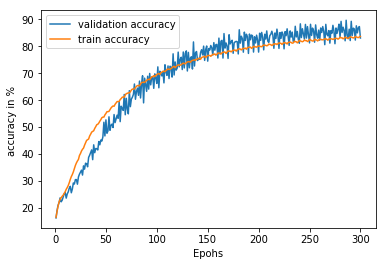

In [18]:
plt.plot([i+1 for i in range(num_epochs)],mean_valid_acc,label="validation accuracy")
plt.plot([i+1 for i in range(num_epochs)],mean_train_acc,label="train accuracy")
plt.legend(loc='best')
plt.xlabel("Epohs")
plt.ylabel("accuracy in % ")
plt.show()

In [19]:
#generating words
print("GENERATING FAKE SHAKESPEARE TEXT: \n________________________________________________________")
num_words=2000 # th number of words that we want to generate
testacc=[]

## what is the first word?  answer:  forx example The
input_word_index=return_index('The')
print('The',end=" ")
X=torch.autograd.Variable(torch.LongTensor(np.array([input_word_index]).reshape(1,1)))
hidden = model.init_hidden(1)

for i in range(num_words):

    if cuda.is_available():
            X = X.cuda()
           
  
  
#     print(hidden.shape)
    outputs,hidden=model(X,hidden)# outputs shape:  torch.Size([seq_lenght , batch_size, vocab_size])
    outputs=outputs.view(vocab_size)
    outExp=outputs.exp()
#     print(outputs)
    probablistic_output=(outExp)/(outExp.sum())# probablistic_output shape: torch.Size([vocab_size])
#     probablistic_output=((outputs)/(0.4)).exp()

    word_index = (torch.multinomial(probablistic_output, 1))
    X=torch.autograd.Variable((word_index).reshape(1,1))
    if(voc[word_index]=="<end>"):
      print("")
    else:
      print(voc[word_index],end=" ")



GENERATING FAKE SHAKESPEARE TEXT: 
________________________________________________________
The pine and let thee out. 

KING RICHARD III: 
And long let me be pleased, what's that to seek again. 

KING RICHARD II: 
Norfolk, throw down, we bid; there is no boot. 

THOMAS MOWBRAY: 
Myself I throw, dread sovereign, at thy foot. 
My life thou shalt command, but not my shame: 
The one that calls our sentence then, the fault's thus manifested; 
Which, though thou wouldst for well afford a grave 
As thou canst yield a melancholy seat! 
Then would I hide my bones, not rest them here. 
I do repent. Alas! I have long in this deep despair? 

QUEEN ELIZABETH: 
From one that long detain'd you from your grace. 

ROMEO: 
I hear no more: die, 'tis not a maid. 

DUCHESS: 
Where shall arm me resign my father, 
But what he can abet him in this kind 
Cherish rebellion and are rebels all. 

NORTHUMBERLAND: 
My right is noble and fair earth, 
Who lately made here? Yet thou had there I have spoke, 
My old ma